<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ai-powered-search/13-semantic-search/02_autocomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Autocomplete

In [ ]:
!pip install sentence_transformers
!pip install nmslib

In [ ]:
!pip install nmslib

In [ ]:
!wget https://github.com/treygrainger/ai-powered-search/raw/main/docker/data-science/notebooks/densevectors/outdoors.py

In [4]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as STutil

import spacy
from spacy.matcher import Matcher

import nmslib

from outdoors import *
from plotnine import *

import pandas as pd
import pickle
import json
import tqdm
from IPython.display import display,HTML
pd.set_option('display.max_rows', 1000)

##Load Dataset

In [5]:
!rm -rf outdoors

In [6]:
#outdoors
!mkdir -p outdoors

!git clone https://github.com/ai-powered-search/outdoors.git
!cd outdoors && cat outdoors.tgz.part_* > outdoors.tgz
!cd outdoors && mkdir -p 'data/outdoors/' && tar -xvf outdoors.tgz -C 'data/outdoors/'

Cloning into 'outdoors'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 70
Receiving objects: 100% (71/71), 1005.42 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (23/23), done.
README.md
concepts.pickle
._guesses.csv
guesses.csv
._guesses_all.json
guesses_all.json
outdoors_concepts.pickle
outdoors_embeddings.pickle
._outdoors_golden_answers.csv
outdoors_golden_answers.csv
._outdoors_golden_answers.xlsx
outdoors_golden_answers.xlsx
._outdoors_golden_answers_20210130.csv
outdoors_golden_answers_20210130.csv
outdoors_labels.pickle
outdoors_question_answering_contexts.json
outdoors_questionanswering_test_set.json
outdoors_questionanswering_train_set.json
._posts.csv
posts.csv
predicates.pickle
pull_aips_dependency.py
._question-answer-seed-contexts.csv
question-answer-seed-contexts.csv
question-answer-squad2-guesses.csv
._roberta-base-squad2-outdoors
roberta

In [7]:
# let's transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('outdoors/data/outdoors/posts.csv')

/content/outdoors.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [8]:
print(len(outdoors_dataframe))

19585


##Build Vocabulary

In [13]:
concepts_pickle_path = "outdoors/data/outdoors/outdoors_concepts.pickle"
labels_pickle_path = "outdoors/data/outdoors/outdoors_labels.pickle"

In [9]:
nlp = spacy.load('en_core_web_sm')

def normalize(span):
    #normalizes a noun or verb phrase
    return ' '.join([tok.lemma_.lower() for tok in span])

def yield_tuple(df,column,total=100):
    #yields a spacy nlp.pipe compliant tuple of the column text values and its dataframe row as the context
    for idx,row in df.iterrows():
        if idx<total:
            yield (row[column],idx)

def get_concepts(df, total=None, load_from_cache=True):

    if load_from_cache:
        with open(concepts_pickle_path,'rb') as fd:
            concepts = pickle.load(fd)
        with open(labels_pickle_path,'rb') as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print('Extracting concepts. This could take a while. Take a break and stretch :)')

    #You can limit the number of rows processed by passing in total (an integer)
    if not total:
        total = len(df)

    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept

    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ['NN','NNP','NNS','NOUN'] #Nouns
    verbtags = ['VB','VBD','VBG','VBN','VBP','VBZ','VERB'] #Verbs
    matcher.add("noun_phrases", [[{"TAG":{"IN": nountags}, "IS_ALPHA": True,"OP":"+"}]])
    matcher.add("verb_phrases", [[{"TAG":{"IN": verbtags}, "IS_ALPHA": True,"OP":"+", "LEMMA":{"NOT_IN":["be"]}}]])
    for doc,idx in tqdm.tqdm(nlp.pipe(yield_tuple(df,"body",total=total), batch_size=40, n_threads=4, as_tuples=True),total=total):
        text = doc.text
        matches = matcher(doc)
        for matchid,start,end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)


    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i in range(len(phrases)):
        phrase = phrases[i]
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1

    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}

    with open(concepts_pickle_path,'wb') as fd:
        pickle.dump(sorted_concepts,fd)
    with open(labels_pickle_path,'wb') as fd:
        pickle.dump(labels,fd)

    return sorted_concepts,labels

What are the concepts with the highest frequency?

In [10]:
# let's do examining the vocabulary
concepts, labels = get_concepts(outdoors_dataframe, load_from_cache=True)
top_cons = {k: v for (k, v) in concepts.items() if v > 5}

print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 5 term frequency: {len(top_cons.keys())}")

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375


In [ ]:
json.dumps(top_cons, indent=2)

##Loading model

In [ ]:
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
print(stsb)

##Getting Embeddings

In [14]:
embeddings_pickle_path = "outdoors/data/outdoors/outdoors_embeddings.pickle"

In [18]:
def get_embeddings(concepts, minimum_frequency, load_from_cache=True):
  phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]

  if not load_from_cache:
    embeddings = stsb.encode(phrases, convert_to_tensor=True)
    with open(embeddings_pickle_path, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(embeddings_pickle_path, "rb") as fd:
      embeddings = pickle.load(fd)
  return phrases, embeddings

In [16]:
# Note!  This is a hyperparameter.
# We are ignoring terms that occur less than this numner in the entire corpus.
# Lowering this number may lower precision
# Raising this number may lower recall
minimum_frequency = 6

In [19]:
# set load_from_cache=False to regenerate the embeddings rather than loading from pickle
phrases, embeddings = get_embeddings(concepts, minimum_frequency, load_from_cache=True)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12375
Dimensions per embedding: 768


##Calculate similarity

In [20]:
# let's find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:250], embeddings[0:250])
print(f"The shape of the resulting similarities: {similarities.shape}")

The shape of the resulting similarities: torch.Size([250, 250])


In [21]:
a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities) - 1):
  for b in range(a + 1, len(similarities)):
    a_phrases.append(phrases[a])
    b_phrases.append(phrases[b])
    scores.append(float(similarities[a][b]))

comparisons_df = pd.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score": scores, "name": "similarity"})
comparisons_df = comparisons_df.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons_df["idx"] = range(len(comparisons_df))
comparisons_df[comparisons_df["score"] > .7]

,phrase a,phrase b,score,name,idx
0,protect,protection,0.928150,similarity,0
1,climbing,climber,0.923570,similarity,1
2,camp,camping,0.878894,similarity,2
3,climb,climbing,0.833662,similarity,3
4,something,someone,0.821081,similarity,4
5,hike,hiking,0.815187,similarity,5
6,people,person,0.784663,similarity,6
7,climb,climber,0.782962,similarity,7
8,go,leave,0.770643,similarity,8
9,keep,stay,0.768612,similarity,9


##Similarity distribution

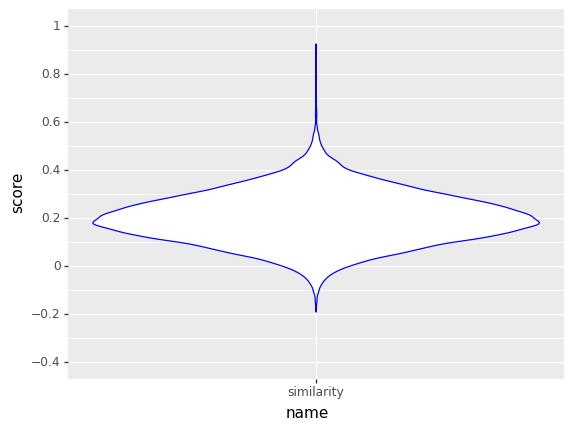

{<ggplot: (8426521149645)>}

In [29]:
# let’s look at the distribution of the resulting similarity scores
{
    ggplot(comparisons_df[:50000], aes("name", "score"))
    + geom_violin(color="blue")
    + scale_y_continuous(limits=[-0.4,1.0], breaks=[-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
}

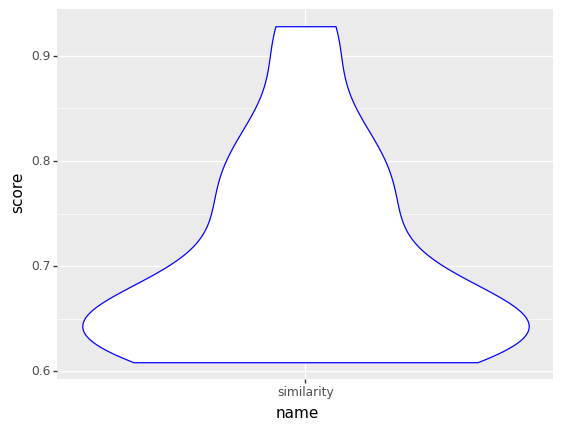

{<ggplot: (8426521207649)>}

In [30]:
# let’s look at the distribution of the resulting similarity scores
candidate_synonyms = comparisons_df[comparisons_df["score"] > 0.6]
{
    ggplot(candidate_synonyms, aes("name", "score"))
    + geom_violin(color="blue")
}

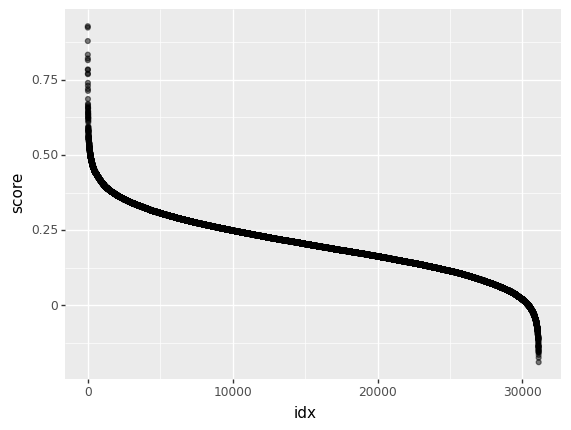

{<ggplot: (8426521088835)>}

In [31]:
{
    ggplot(comparisons_df, aes("idx", "score"))
    + geom_point(alpha=.5)
}

##Approximate Nearest-Neighbor search